In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
# from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh
from sklearn.preprocessing import normalize

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

0:year,1:Start_date,2:ProfitLoss,3:GrossResult,4:Assets,5:AverageNumberOfEmployees,6:Equity,7:AddressOfReportingEntityPostCodeIdentifier

In [4]:
years = 6
data = np.load('data_train_{}.npy'.format(years),allow_pickle=True)
target = np.load('data_target_{}.npy'.format(years),allow_pickle=True)

In [5]:
#Changes address to first number in postcode or 0 if there isn't one
data = data[:,:,2:] 
target = target[:,2:]
'''
0:ProfitLoss,1:GrossResult,2:Assets,3:AverageNumberOfEmployees,4:Equity,5:AddressOfReportingEntityPostCodeIdentifier
'''
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        try:
            data[i,j,5] = int(str(data[i,j,5])[0])
        except:
            data[i,j,5] = 0
for i in range(target.shape[0]):
    try:
        target[i,5] = int(str(target[i,5])[0])
    except:
        target[i,5] = 0

In [6]:
#remove remaining strings
index_of_string = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            try:
                float(data[i,j,k])
            except:
                index_of_string.append((i))
                
index_of_string = np.array(index_of_string)
index_of_string = np.unique(index_of_string)                
data = np.delete(data,index_of_string,axis=0)
target = np.delete(target,index_of_string,axis=0)

D:\Programmer\Anaconda\envs\Deep learning\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]
D:\Programmer\Anaconda\envs\Deep learning\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


In [7]:
#remove nan
nan_ = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            if np.isnan(data[i,j,k]):
                nan_.append(i)
nan_ = np.array(nan_)
nan_ = np.unique(nan_)
data = np.delete(data,nan_,axis=0)
target = np.delete(target,nan_,axis=0)

D:\Programmer\Anaconda\envs\Deep learning\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
D:\Programmer\Anaconda\envs\Deep learning\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


In [8]:
#removes any entry with a zero in profitloss, GrossResult, assets or equity
has_zero = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data[i,j,0] == 0 or data[i,j,1] == 0 or data[i,j,2] == 0 or data[i,j,4] == 0:
            has_zero.append(i)
has_zero = np.unique(np.array(has_zero))
data = np.delete(data,has_zero,axis=0)
target = np.delete(target,has_zero,axis=0)

In [9]:
big_company_pos = []
medium_company_pos = []
small_company_pos = []
big_company_neg = []
medium_company_neg = []
small_company_neg = []

for i in range(data.shape[0]):
    if np.median(data[i,:,1]) < 0:
        if np.mean(data[i,:,2]) < 100000:
            small_company_neg.append(i)
        elif np.mean(data[i,:,2]) > 100000 and np.mean(data[i,:,2]) < 10000000:
            medium_company_neg.append(i)
        else:
            big_company_neg.append(i)
    else:
        if np.mean(data[i,:,2]) < 100000:
            small_company_pos.append(i)
        elif np.mean(data[i,:,2]) > 100000 and np.mean(data[i,:,2]) < 10000000:
            medium_company_pos.append(i)
        else:
            big_company_pos.append(i)

print(len(small_company_neg))
print(len(small_company_pos))
print(len(medium_company_neg))
print(len(medium_company_pos))
print(len(big_company_neg))
print(len(big_company_pos))

86
19
1666
2568
516
878


In [10]:
# small_company = []
# medium_company = []
# big_company = []
# for i in range(data.shape[0]):
#     if np.mean(data[i,:,2]) < 100000:
#         small_company.append(i)
#     elif np.mean(data[i,:,2]) > 100000 and np.mean(data[i,:,2]) < 10000000:
#         medium_company.append(i)
#     else:
#         big_company.append(i)
        
# print(len(small_company))        
# print(len(medium_company))
# print(len(big_company))

In [11]:
data = data.astype("float")
target = target.astype("float")

In [12]:
data = data[medium_company_pos]
target = target[medium_company_pos]
# data_small = data[small_company]
# target_small = target[small_company]
# data_medium = data[medium_company]
# target_medium = target[medium_company]

In [13]:
data = data[:,:,0:3]
features = data.shape[2]

In [14]:
data = torch.from_numpy(data).float()
# data = data.permute(0,2,1) # Needed if using CNN
target = torch.from_numpy(target).float()

#target index
target_index = 1

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)

train_data = data[train_idx,:,:]
train_target = target[train_idx,target_index] 
test_data = data[test_idx,:,:]
test_target = target[test_idx,target_index]

trainset = dataset(train_data,train_target)
testset = dataset(test_data,test_target)

In [15]:
# #for data_grouped.npy
# zeros_ = np.zeros(6)
# for i in range(6):
#     temp = data[:,:,i].clone()
#     zeros_[i] = temp[temp==0].shape[0]
    
# pct_zeros = zeros_/(data.shape[0]*3)
# print('0:ProfitLoss, 1:GrossResult, 2:Assets,3:AverageNumberOfEmployees, 4:Equity, 5:AddressOfReportingEntityPostCodeIdentifier')
# print(pct_zeros)

In [16]:
batch_size=100

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

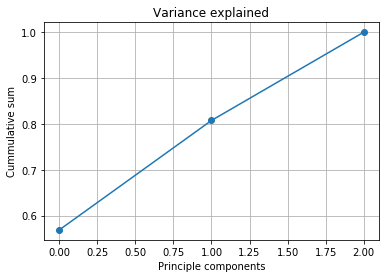

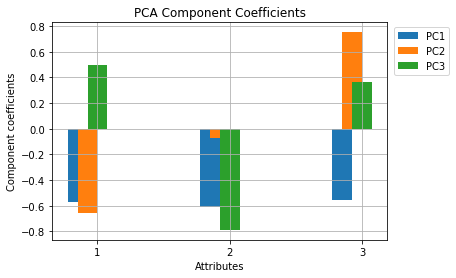

In [17]:
temp = data.clone()
temp = temp.view(temp.shape[0]*temp.shape[1],temp.shape[2])
temp = temp.numpy()

# #standardize data 
temp = temp-np.ones((temp.shape[0],1))*temp.mean(0)
temp = temp*(1/np.std(temp,0))
#compute covariance matrix
S = np.cov(temp.T)

#obtain eigen values and eigen vectors
eigenValues, eigenVectors = eigh(S)
idx_ord = np.argsort(eigenValues)[::-1]
eigenValues = eigenValues[idx_ord]
eigenVectors = eigenVectors[:,idx_ord]

#plot cummulative variance explained    
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(features)
for i in range(features):    
    cumsum = cumsum + eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig, ax = plt.subplots()
ax.plot(total_var_explained,'-o')
#ax.axhline(0.90,linestyle='--')
plt.grid();
#plt.xlim(-1,50)
#plt.ylim(0,1)
plt.title('Variance explained' )
plt.ylabel('Cummulative sum')
plt.xlabel('Principle components')
# plt.savefig("variance_explained")
plt.show()

M=features
pcs = np.arange(features)
#pcs = np.array([3,10])
legendStrs = ['PC'+str(e+1) for e in pcs]
c = ['r','g','b']
bw = .15
r = np.arange(1,M+1)
for i in pcs:    
   plt.bar(r+i*bw/2, eigenVectors[:,i], width=bw)
plt.xticks(r+bw, np.arange(1,13))
plt.xlabel('Attributes')
plt.ylabel('Component coefficients')
plt.legend(legendStrs,loc=1, bbox_to_anchor=(1.2,1))
plt.grid()
plt.title('PCA Component Coefficients')
plt.show()

In [18]:
# #Picking principle components to project the data into
# eigenvectors1 = eigenVectors[:, 0]
# eigenvectors2 = eigenVectors[:, 1]
# eigenvectors3 = eigenVectors[:, 2]
# eigenvectors4 = eigenVectors[:, 3]
# eigenvectors = np.vstack((eigenvectors1,eigenvectors2,eigenvectors3,eigenvectors4)).T

# ## now we have to project our vectors in this new base
# transformed_data = temp @ eigenvectors

# fig,ax = plt.subplots(3,1,figsize=(10,15))
# ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1])
# ax[0].set_title('Data projection into 2D PC space')
# ax[0].set_xlabel('Principle component 1')
# ax[0].set_ylabel('Principle component 2')
# ax[1].scatter(transformed_data[:, 0], transformed_data[:, 2])
# ax[1].set_title('Data projection into 2D PC space')
# ax[1].set_xlabel('Principle component 1')
# ax[1].set_ylabel('Principle component 3')
# ax[2].scatter(transformed_data[:, 0], transformed_data[:, 3])
# ax[2].set_title('Data projection into 2D PC space')
# ax[2].set_xlabel('Principle component 1')
# ax[2].set_ylabel('Principle component 4')
# #plt.rcParams.update({'figure.autolayout': True})
# plt.show()

In [19]:
class RecurrentNetSkip(nn.Module):
    def __init__(self,years,p):
        super(RecurrentNetSkip, self).__init__()
        
#         self.linearIn = nn.Sequential(nn.Linear(in_features=years,out_features=6),
#                                       nn.ReLU(),
#                                       nn.Linear(6,10)) 
        self.rnn = nn.GRU(input_size=features,
                          hidden_size=10,
                          num_layers=years,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=(10+features)*years,out_features=50),
                                       nn.ReLU(),
                                       nn.Dropout(p=p),
                                       nn.Linear(50,20),
                                       nn.ReLU(),
                                       nn.Dropout(p=p),
                                       nn.Linear(20,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,years,6]
        
#         x1 = self.linearIn(x[:,0,:]) #[batch_size,6]
#         x2 = self.linearIn(x[:,1,:]) #[batch_size,6]
#         x3 = self.linearIn(x[:,2,:]) #[batch_size,6]
#         x1 = x1.unsqueeze(1) #[batch_size,1,6]
#         x2 = x2.unsqueeze(1) #[batch_size,1,6]
#         x3 = x3.unsqueeze(1) #[batch_size,1,6]     
#         temp = []
#         temp.append(x1)
#         temp.append(x2)
#         temp.append(x3)
#         z = torch.cat(temp,dim=1) #[batch_size,3,6]
        
#         y = torch.cat((z,x),dim=2) #[batch_size,3,12]
                                            
        y,_ = self.rnn(x) #[batch_size,years,50]
        
        x = torch.cat((x,y),dim=2) #[batch_size,years,50+3]
        
        x = x.reshape(x.shape[0],-1) #[batch_size,(50+3)*years]
                       
        x = self.linearOut(x) #[batch_size,1], [batch_size,2] if predicting normal distribution
        x = x.view(-1)
        return x


In [20]:
class RecurrentNet(nn.Module):
    def __init__(self,years,p):
        super(RecurrentNet, self).__init__()
        
#         self.linearIn = nn.Sequential(nn.Linear(in_features=years,out_features=6),
#                                       nn.ReLU(),
#                                       nn.Linear(6,10)) 
        self.rnn = nn.GRU(input_size=features,
                          hidden_size=10,
                          num_layers=years,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=10*years,out_features=50),
                                       nn.ReLU(),
                                       nn.Dropout(p=p),
                                       nn.Linear(50,20),
                                       nn.ReLU(),
                                       nn.Dropout(p=p),
                                       nn.Linear(20,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,years,3]
#         x1 = self.linearIn(x[:,0,:]) #[batch_size,6]
#         x2 = self.linearIn(x[:,1,:]) #[batch_size,6]
#         x3 = self.linearIn(x[:,2,:]) #[batch_size,6]
#         x1 = x1.unsqueeze(1) #[batch_size,1,6]
#         x2 = x2.unsqueeze(1) #[batch_size,1,6]
#         x3 = x3.unsqueeze(1) #[batch_size,1,6]     
#         temp = []
#         temp.append(x1)
#         temp.append(x2)
#         temp.append(x3)
#         x = torch.cat(temp,dim=1) #[batch_size,3,6]
                                            
        x,_ = self.rnn(x) #[batch_size,years,50]
        
        x = x.reshape(x.shape[0],-1) #[batch_size,50*years]
                       
        x = self.linearOut(x) #[batch_size,1], [batch_size,2] if predicting normal distribution
        x = x.view(-1)
        return x


In [21]:
class LinearNet(nn.Module):
    def __init__(self,years,p):
        super(LinearNet, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=features*years,out_features=40),
                                   nn.ReLU(),
                                   nn.Dropout(p=p),
                                   nn.Linear(40,60),
                                   nn.ReLU(),
                                   nn.Dropout(p=p),
                                   nn.Linear(60,20),
                                   nn.ReLU(),
                                   nn.Dropout(p=p),
                                   nn.Linear(20,1))

        
    def forward(self, x): #x = [batch_size,3,3]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        x = x.view(-1)
        return x


In [22]:
def cost(mu,sigma,y):
    sigma = torch.abs(sigma)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

def percent_loss(pred,target):
    count_bad_pred = 0
    temp = pred < torch.ones(pred.shape[0])*1000
    temp2 = pred > torch.ones(pred.shape[0])*-1000
    for i in range(pred.shape[0]):
        if temp[i] == temp2[i]:
            count_bad_pred += 1

    return torch.sum(torch.abs(torch.abs(pred-target)/(target+1)))+count_bad_pred*10000

In [36]:
model1 = LinearNet(years,0.15)
model2 = RecurrentNet(years,0.15)
model3 = RecurrentNetSkip(years,0.15)

# model1 = RecurrentNet(years,0.15)

model1.to(device)
model2.to(device)
model3.to(device)
lr = 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)
optimizer3 = optim.Adam(model3.parameters(), lr=lr)

critirion = nn.SmoothL1Loss()

In [37]:
#Training loop
num_epochs = 50
train_loss1 = []
test_loss1 = []
train_loss2 = []
test_loss2 = []
train_loss3 = []
test_loss3 = []

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error1 = 0
    train_error2 = 0
    train_error3 = 0
    model1.train()
    model2.train()
    model3.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        #Forward pass your image through the network
        output1 = model1(data)
        output2 = model2(data)
        output3 = model3(data)
        #Compute the loss
#         loss1 = percent_loss(output1,target)
#         loss2 = percent_loss(output2,target)
#         loss3 = percent_loss(output3,target)
        loss1 = critirion(output1,target)
        loss2 = critirion(output2,target)
        loss3 = critirion(output3,target)

        #Backward pass through the network
        loss1.backward()
        loss2.backward()
        loss3.backward()
        #Update the weights
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        train_error1 += loss1
        train_error2 += loss2
        train_error3 += loss3
        
        
    #Comput the test accuracy
    model1.eval()
    model2.eval()
    model3.eval()
    test_error1 = 0
    test_error2 = 0
    test_error3 = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output1 = model1(data)
            output2 = model2(data)
            output3 = model3(data)
#         test_error1 += percent_loss(output1,target)
#         test_error2 += percent_loss(output2,target)
#         test_error3 += percent_loss(output3,target)
        test_error1 += critirion(output1,target)
        test_error2 += critirion(output2,target)
        test_error3 += critirion(output3,target)
        
    train_err1 = train_error1/len(trainset)
    train_loss1.append(train_err1)
    test_err1 = test_error1/len(testset)
    test_loss1.append(test_err1)
    train_err2 = train_error2/len(trainset)
    train_loss2.append(train_err2)
    test_err2 = test_error2/len(testset)
    test_loss2.append(test_err2)
    train_err3 = train_error3/len(trainset)
    train_loss3.append(train_err3)
    test_err3 = test_error3/len(testset)
    test_loss3.append(test_err3)
    print("train error 1: {train1:.1f}\t test error 1: {test1:.1f}\n train error 2: {train2:.1f}\t test error 2: {test2:.1f}\n train error 3: {train3:.1f}\t test error 3: {test3:.1f}".format(test1=test_err1, test2=test_err2, test3=test_err3, train1=train_err1, train2=train_err2, train3=train_err3))
#     print("train error 1: {train1:.1f}\t test error 1: {test1:.1f}".format(test1=test_err1,train1=train_err1))


train error 1: 16891.8	 test error 1: 16571.4
 train error 2: 19910.3	 test error 2: 23976.1
 train error 3: 18945.1	 test error 3: 19334.7



train error 1: 11349.8	 test error 1: 11092.6
 train error 2: 19590.8	 test error 2: 23976.1
 train error 3: 14042.2	 test error 3: 13799.2



train error 1: 7830.2	 test error 1: 9664.1
 train error 2: 19911.2	 test error 2: 23975.9
 train error 3: 9190.2	 test error 3: 9759.1



train error 1: 7449.6	 test error 1: 8673.0
 train error 2: 19814.3	 test error 2: 23975.6
 train error 3: 7901.9	 test error 3: 8642.6



train error 1: 6950.1	 test error 1: 8374.4
 train error 2: 19645.5	 test error 2: 23975.0
 train error 3: 6991.3	 test error 3: 8022.1



train error 1: 6937.7	 test error 1: 7796.0
 train error 2: 19851.1	 test error 2: 23974.0
 train error 3: 6955.0	 test error 3: 7375.1



train error 1: 6736.7	 test error 1: 7826.3
 train error 2: 20105.2	 test error 2: 23972.5
 train error 3: 6582.0	 test error 3: 7283.2



train error 1: 7070.1	 test error 1: 7687.7
 train error 2: 20238.3	 test error 2: 23970.4
 train error 3: 6942.2	 test error 3: 7542.2



train error 1: 6609.2	 test error 1: 7643.1
 train error 2: 19846.5	 test error 2: 23967.6
 train error 3: 6309.2	 test error 3: 7208.4



train error 1: 6270.2	 test error 1: 7412.3
 train error 2: 19737.6	 test error 2: 23964.0
 train error 3: 6323.7	 test error 3: 7148.7



train error 1: 6878.4	 test error 1: 7226.6
 train error 2: 20492.7	 test error 2: 23959.6
 train error 3: 6560.0	 test error 3: 6863.8



train error 1: 6335.1	 test error 1: 7102.4
 train error 2: 19641.1	 test error 2: 23954.2
 train error 3: 6234.4	 test error 3: 6623.3



train error 1: 6666.6	 test error 1: 6999.9
 train error 2: 20168.5	 test error 2: 23947.8
 train error 3: 6278.3	 test error 3: 6653.3



train error 1: 6271.9	 test error 1: 7656.2
 train error 2: 19724.6	 test error 2: 23940.3
 train error 3: 6257.9	 test error 3: 6823.8



train error 1: 6281.4	 test error 1: 7419.8
 train error 2: 20181.2	 test error 2: 23931.5
 train error 3: 6317.5	 test error 3: 6534.5



train error 1: 6311.4	 test error 1: 7748.3
 train error 2: 19688.3	 test error 2: 23921.5
 train error 3: 5911.0	 test error 3: 6510.2



train error 1: 6454.5	 test error 1: 7789.7
 train error 2: 19671.6	 test error 2: 23910.2
 train error 3: 6015.2	 test error 3: 6784.7



train error 1: 6203.5	 test error 1: 7012.2
 train error 2: 19775.0	 test error 2: 23897.9
 train error 3: 6129.8	 test error 3: 6782.8



train error 1: 6142.5	 test error 1: 7472.7
 train error 2: 20032.8	 test error 2: 23883.8
 train error 3: 6036.7	 test error 3: 6806.5



train error 1: 5956.9	 test error 1: 7104.2
 train error 2: 19922.9	 test error 2: 23868.2
 train error 3: 5787.6	 test error 3: 6618.0



train error 1: 6117.5	 test error 1: 7392.9
 train error 2: 20428.0	 test error 2: 23851.2
 train error 3: 6403.0	 test error 3: 6552.1



train error 1: 6022.7	 test error 1: 7785.5
 train error 2: 19613.0	 test error 2: 23832.4
 train error 3: 5635.4	 test error 3: 6456.4



train error 1: 5978.7	 test error 1: 6917.3
 train error 2: 19562.1	 test error 2: 23812.1
 train error 3: 5597.5	 test error 3: 6379.6



train error 1: 5977.4	 test error 1: 6747.3
 train error 2: 19986.0	 test error 2: 23790.6
 train error 3: 5718.1	 test error 3: 6331.6



train error 1: 6053.9	 test error 1: 6903.0
 train error 2: 19684.2	 test error 2: 23767.0
 train error 3: 5612.0	 test error 3: 6639.0



train error 1: 5775.4	 test error 1: 7300.3
 train error 2: 19239.1	 test error 2: 23741.7
 train error 3: 5674.0	 test error 3: 6589.9



train error 1: 5931.4	 test error 1: 6983.7
 train error 2: 20367.1	 test error 2: 23714.5
 train error 3: 5540.7	 test error 3: 6461.5



train error 1: 5957.8	 test error 1: 6773.5
 train error 2: 19534.6	 test error 2: 23685.5
 train error 3: 5698.6	 test error 3: 6378.1



train error 1: 6176.0	 test error 1: 6754.4
 train error 2: 20046.7	 test error 2: 23655.8
 train error 3: 5994.3	 test error 3: 6553.7



train error 1: 5875.7	 test error 1: 6779.6
 train error 2: 19401.6	 test error 2: 23624.0
 train error 3: 5672.1	 test error 3: 6382.5



train error 1: 6070.6	 test error 1: 7034.9
 train error 2: 19575.9	 test error 2: 23590.4
 train error 3: 5538.1	 test error 3: 6577.2



train error 1: 6060.8	 test error 1: 6810.0
 train error 2: 19894.2	 test error 2: 23555.0
 train error 3: 5792.0	 test error 3: 6767.4



train error 1: 5794.1	 test error 1: 6668.7
 train error 2: 19675.3	 test error 2: 23518.6
 train error 3: 5792.8	 test error 3: 6502.7



train error 1: 5890.8	 test error 1: 6606.8
 train error 2: 19031.8	 test error 2: 23481.3
 train error 3: 5636.4	 test error 3: 6682.7



train error 1: 6571.8	 test error 1: 6738.5
 train error 2: 20452.5	 test error 2: 23442.6
 train error 3: 6258.5	 test error 3: 6358.9



train error 1: 6131.5	 test error 1: 7830.8
 train error 2: 19923.9	 test error 2: 23402.7
 train error 3: 5832.1	 test error 3: 7283.1



train error 1: 6331.0	 test error 1: 7496.0
 train error 2: 19818.8	 test error 2: 23360.0
 train error 3: 5981.5	 test error 3: 6919.0



train error 1: 5845.6	 test error 1: 6968.3
 train error 2: 19311.2	 test error 2: 23316.6
 train error 3: 5793.7	 test error 3: 6854.7



train error 1: 5429.3	 test error 1: 6672.6
 train error 2: 18968.7	 test error 2: 23271.5
 train error 3: 5774.5	 test error 3: 6453.3



train error 1: 5758.2	 test error 1: 6871.2
 train error 2: 19224.9	 test error 2: 23228.4
 train error 3: 5571.4	 test error 3: 6466.9



train error 1: 5677.6	 test error 1: 6643.7
 train error 2: 19137.4	 test error 2: 23182.1
 train error 3: 5613.9	 test error 3: 6628.4



train error 1: 5827.9	 test error 1: 6851.1
 train error 2: 18969.7	 test error 2: 23134.9
 train error 3: 5564.2	 test error 3: 6440.1



train error 1: 5962.3	 test error 1: 6814.8
 train error 2: 19439.9	 test error 2: 23087.5
 train error 3: 5903.7	 test error 3: 6771.6



train error 1: 5670.9	 test error 1: 6840.9
 train error 2: 18933.7	 test error 2: 23039.5
 train error 3: 5475.8	 test error 3: 6420.7



train error 1: 5692.0	 test error 1: 6798.8
 train error 2: 18712.4	 test error 2: 22992.3
 train error 3: 5453.1	 test error 3: 6660.7



train error 1: 5537.7	 test error 1: 7192.4
 train error 2: 18842.0	 test error 2: 22946.7
 train error 3: 5619.4	 test error 3: 6774.1



train error 1: 5874.8	 test error 1: 6660.6
 train error 2: 19389.9	 test error 2: 22901.3
 train error 3: 5589.5	 test error 3: 6612.9



train error 1: 5647.2	 test error 1: 7257.3
 train error 2: 18654.9	 test error 2: 22854.8
 train error 3: 5556.2	 test error 3: 6567.4



train error 1: 5669.3	 test error 1: 6893.4
 train error 2: 19197.5	 test error 2: 22809.6
 train error 3: 5563.8	 test error 3: 6429.3



train error 1: 5677.2	 test error 1: 6871.5
 train error 2: 18634.6	 test error 2: 22762.5
 train error 3: 5602.3	 test error 3: 6705.8



In [38]:
print(target[:10])
temp =model1(data[:10])
print(temp)

tensor([ 3856778.,  2752409.,    77206.,   482690.,    50861., 19779996.,
         4825603.,  1142114.,   753224.,  1632679.], device='cuda:0')
tensor([4.4304e+06, 2.3182e+06, 2.5494e+03, 3.7178e+05, 4.7685e+04, 1.0241e+07,
        4.6380e+06, 1.0772e+06, 3.2579e+05, 1.6432e+06], device='cuda:0',
       grad_fn=<ViewBackward>)


In [39]:
#predicts the average over the last 3 years
baseline_loss = 0
for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):  
    y_pred = data[:,:,0].mean(1)
#     y_pred = data.mean(1)
    loss = critirion(y_pred,target)
#     loss = percent_loss(y_pred,target)
    baseline_loss += loss.numpy()
baseline_loss /= len(trainset)
print("baseline error: {error:.1f}".format(error =baseline_loss))


baseline error: 18610.8


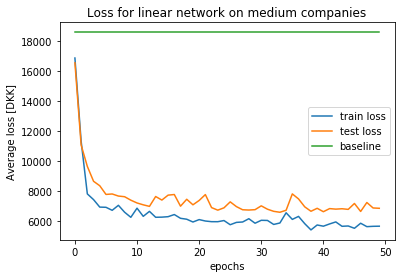

In [40]:
plt.plot(train_loss1)
plt.plot(test_loss1)
plt.plot(np.ones(num_epochs)*baseline_loss)
plt.legend(["train loss","test loss","baseline"])
plt.title("Loss for linear network on medium companies")
plt.xlabel("epochs")
plt.ylabel("Average loss [DKK]")
# plt.savefig("../images/linear_loss_{}_features_{}_years_positive".format(features,years))
plt.show()

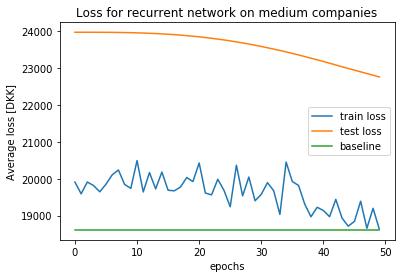

In [41]:
plt.plot(train_loss2)
plt.plot(test_loss2)
plt.plot(np.ones(num_epochs)*baseline_loss)
plt.legend(["train loss","test loss","baseline"])
plt.title("Loss for recurrent network on medium companies")
plt.xlabel("epochs")
plt.ylabel("Average loss [DKK]")
# plt.savefig("../images/recurrent_loss_{}_features_{}_years_positive".format(features,years))
plt.show()

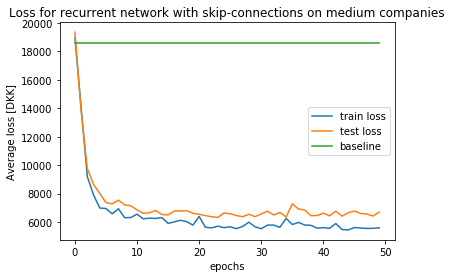

In [42]:
plt.plot(train_loss3)
plt.plot(test_loss3)
plt.plot(np.ones(num_epochs)*baseline_loss)
plt.legend(["train loss","test loss","baseline"])
plt.title("Loss for recurrent network with skip-connections on medium companies")
plt.xlabel("epochs")
plt.ylabel("Average loss [DKK]")
# plt.savefig("../images/recurrentskip_loss_{}_features_{}_years_positive".format(features,years))
plt.show()

In [30]:
# torch.save(model1.state_dict(),"linear_network_{}_features_{}_years_positive".format(features,years))
# torch.save(model2.state_dict(),"recurrent_network_{}_features_{}_years_positive".format(features,years))
# torch.save(model3.state_dict(),"recurrent_skip_network_{}_features_{}_years_positive".format(features,years))